In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings as wr
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from pathlib import Path

wr.filterwarnings('ignore')

work_dir = Path.cwd().parent.parent / 'Work'
df = pd.read_excel(work_dir / "summary_tests.xlsx")

df

,Unnamed: 0,T258_dH+_mean,T258_dH+_std,T258_dH+_min,T258_dH+_25%,T258_dH+_50%,T258_dH+_75%,T258_dH+_max,T258_dH-_mean,T258_dH-_std,...,T278_SMR_diff_min,T278_SMR_diff_25%,T278_SMR_diff_50%,T278_SMR_diff_75%,T278_SMR_diff_max,T278_SMR_corr,T278_SMR_tau,id_sample,age,sex
0,0,2.923077,1.605280,1,2.00,2.0,4.00,5,1.769231,1.739437,...,-0.854969,-0.084948,-0.039704,0.080041,0.382190,-0.456972,-0.266667,0,10.219178,1
1,1,4.000000,2.645751,1,2.00,3.0,5.00,10,2.230769,2.521701,...,-0.737864,-0.101190,-0.002004,0.089127,0.214953,-0.144567,0.015385,1,11.331507,0
2,2,3.000000,1.414214,1,2.00,3.0,4.00,5,0.769231,2.773501,...,-0.312871,-0.113636,-0.029562,0.008153,0.397260,-0.599937,-0.450188,2,11.465753,0
3,3,2.846154,1.772294,1,2.00,2.0,4.00,7,1.538462,2.875627,...,-0.860465,-0.154362,-0.041209,0.100264,0.459375,-0.266544,-0.130703,3,11.701370,0
4,4,4.384615,2.063107,2,2.00,4.0,6.00,8,0.846154,1.214232,...,-0.913232,-0.115234,-0.018072,0.052930,0.500554,-0.184131,-0.103854,4,12.304110,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,3219,15.538462,10.063261,7,9.00,12.0,19.00,42,5.307692,3.326275,...,-0.261944,-0.103728,-0.051200,0.083958,0.212740,-0.194597,-0.159420,3219,83.567123,1
3220,3220,4.692308,2.015962,2,3.00,5.0,6.00,8,2.153846,1.405119,...,-1.381188,-0.099881,-0.014825,0.039242,0.610707,-0.118538,-0.200618,3220,84.380822,0
3221,3221,12.916667,5.350588,6,8.75,12.0,15.25,23,1.500000,1.834022,...,-0.784203,-0.134588,0.049347,0.110667,0.220359,-0.186524,-0.166667,3221,86.531507,0
3222,3222,7.384615,4.213836,2,5.00,6.0,8.00,17,2.461538,2.787334,...,-0.373239,-0.112847,-0.003512,0.052903,0.303716,-0.474331,-0.356436,3222,87.306849,1


In [4]:
delete_columns = ['id_sample', 'age', 'sex', 'Unnamed: 0']
features = [column for column in df.columns if column not in delete_columns]

def split_data(
    df_dataset,
    cols,
    scaler,
    target_col='age',
    test_size=0.2,
    valid_size=0.2,
    random_state=42,
    get_valid_data=True
):
    X_train, X_test, y_train, y_test = train_test_split(
        df_dataset[cols],
        df_dataset[target_col],
        test_size=test_size,
        random_state=random_state
    )
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled, columns=cols, index=X_train.index)
    X_test = pd.DataFrame(X_test_scaled, columns=cols, index=X_test.index)
    
    if not get_valid_data:
        return X_train, X_test, y_train, y_test
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train,
        y_train,
        test_size=valid_size,
        random_state=random_state
    )
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

    

scaler = MinMaxScaler()
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, features, scaler=scaler)  



grid_space = {'n_neighbors': [3, 5, 7, 10, 15, 20, 25, 30],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev']
}

grid = GridSearchCV(KNeighborsRegressor(), 
                    grid_space, 
                    cv=5, 
                    scoring='neg_mean_absolute_error'
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший результат:", grid.best_score_)

knn = KNeighborsRegressor(n_neighbors=15, weights='uniform', metric='manhattan') #обучяем модель
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)  # используем модель на обучающей выборке
train_mae = mean_absolute_error(y_train, y_train_pred)
print("MAE при обучающей выборке:", train_mae)

y_valid_pred = knn.predict(X_valid)  # используем модель на валидационной выборке
val_mae = mean_absolute_error(y_valid, y_valid_pred)
print("MAE при валидационной выборке:", val_mae)

y_test_pred = knn.predict(X_test)  #на тестовой
test_mae = mean_absolute_error(y_test, y_test_pred)
print("MAE при тестовой выборке:", test_mae)

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Лучший результат: -8.470976150957613
MAE при обучающей выборке: 7.822357793433777
MAE при валидационной выборке: 7.812425117694948
MAE при тестовой выборке: 9.088188538458818


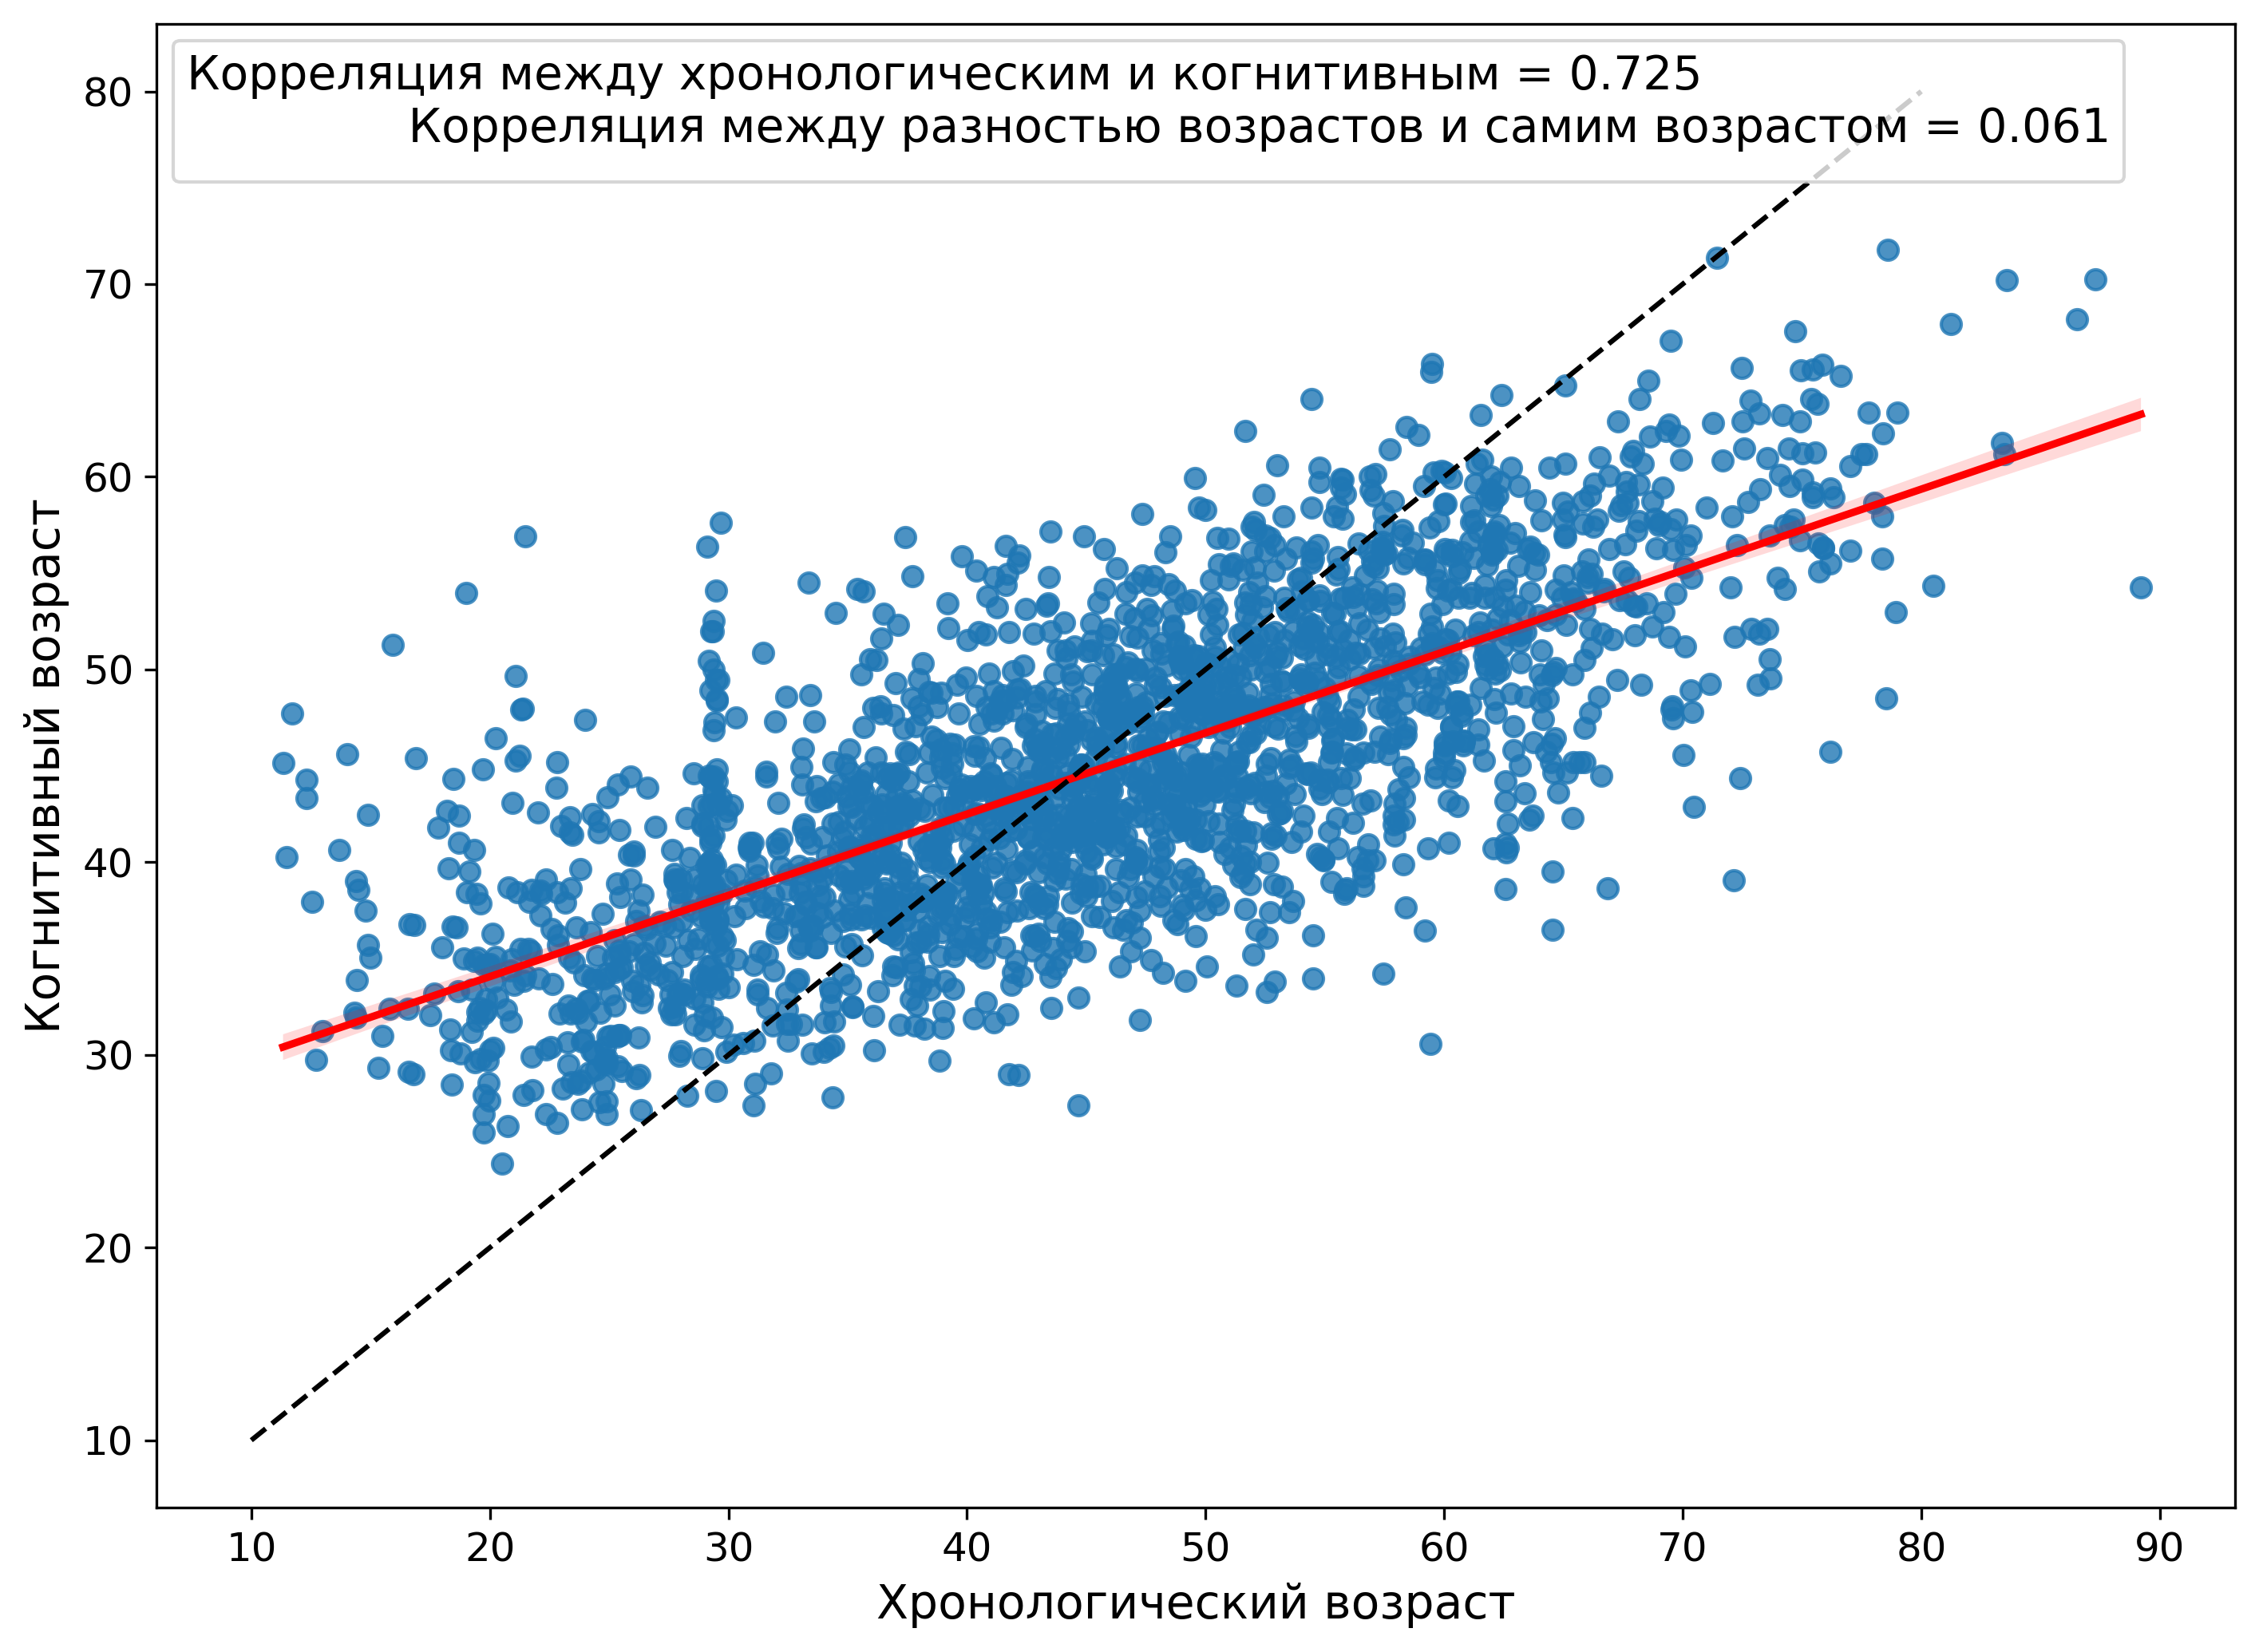

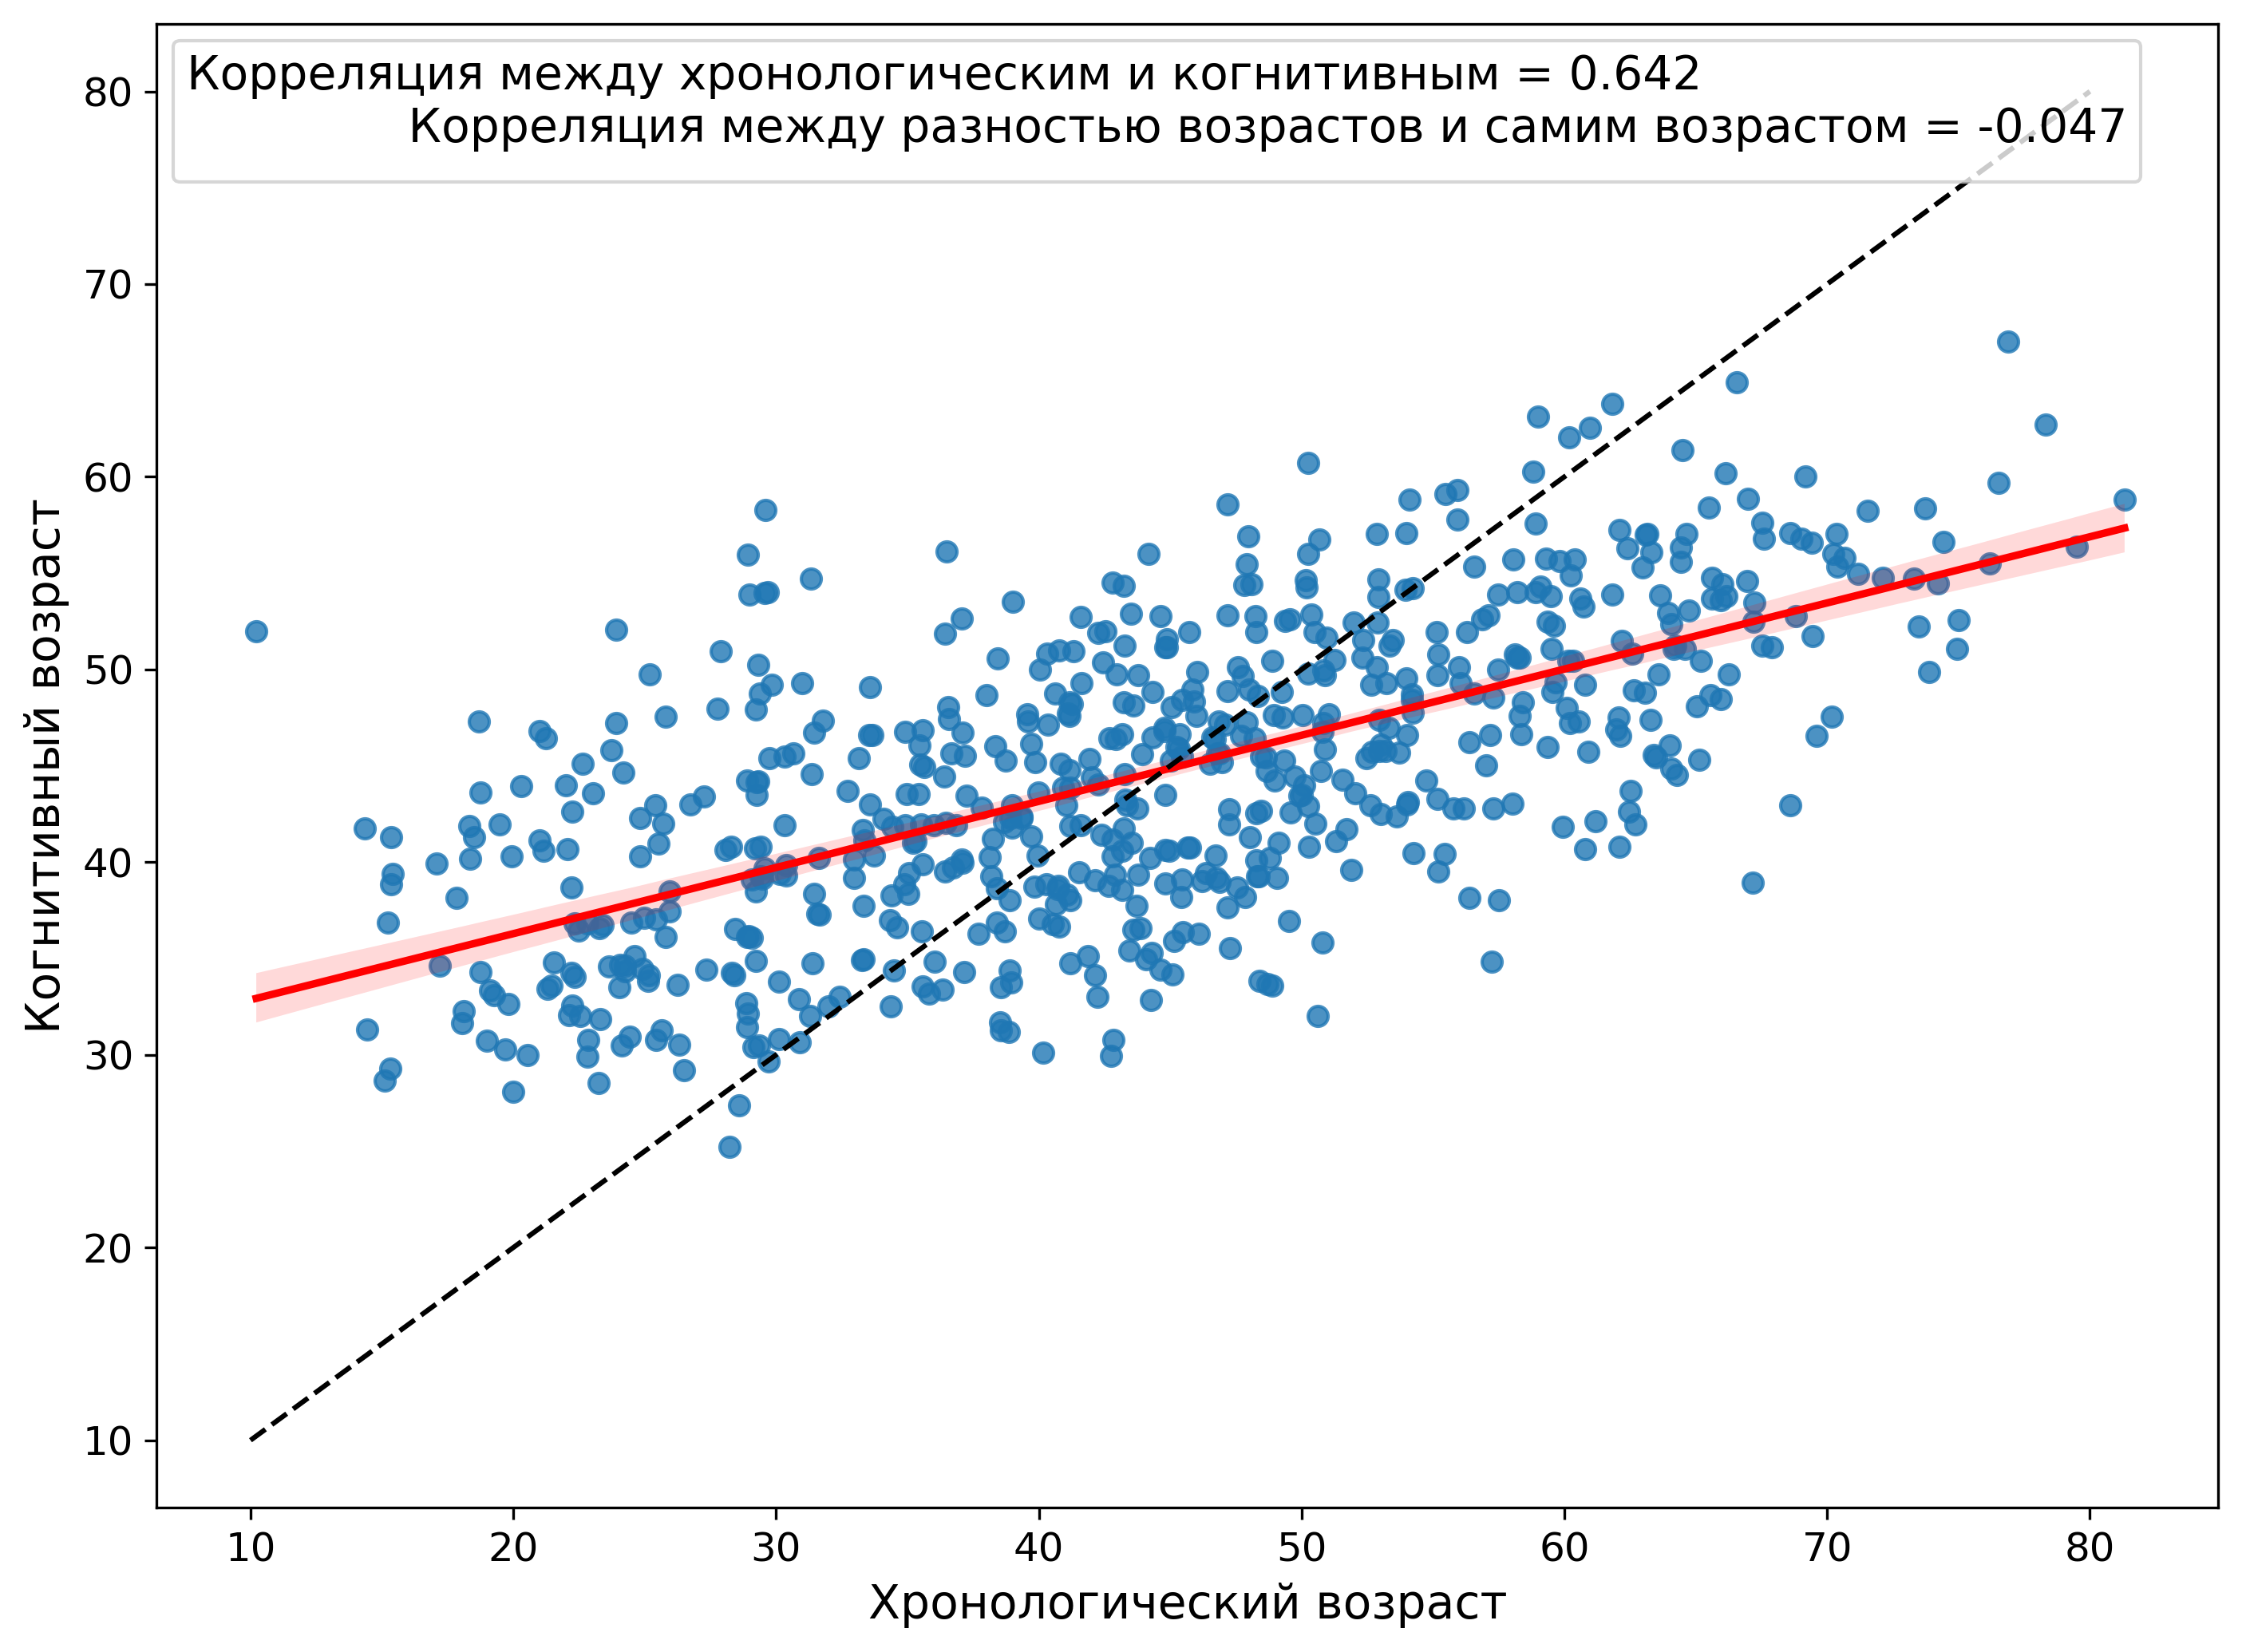

In [5]:
def scatterplot_with_ages(y1, y2): 
    ages_df = pd.DataFrame({
        'Хронологический возраст': y1,
        'Когнитивный возраст': y2
    })

    plt.figure(figsize=(10, 7), dpi=300)

    r1, p = pearsonr(y1, y2)
    r2, p = spearmanr(abs(y2 - y1), y1)
    sns.regplot(
        data=ages_df,
        x='Хронологический возраст',
        y='Когнитивный возраст',
        line_kws={'color': 'red'}
    )
    
    plt.legend(title=f'Корреляция между хронологическим и когнитивным = {round(r1, 3)}\n\
               Корреляция между разностью возрастов и самим возрастом = {round(r2, 3)}', loc='upper left', title_fontsize=14)
    # TODO другую корреляцию для |y2 - y1|, y1
    plt.plot([10, 80], [10, 80], 'k--') 
    plt.xlabel('Хронологический возраст', fontsize = 14)
    plt.ylabel('Когнитивный возраст', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


scatterplot_with_ages(y_train, y_train_pred)
scatterplot_with_ages(y_test, y_test_pred)